In [104]:
from project_heart.lv import LV
import numpy as np
import pyvista as pv
pv.set_jupyter_backend("pythreejs")

import os
from pathlib import Path

from project_heart.enums import *

In [2]:
float_formatter = "{:.5f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

# Load File

In [3]:
_dir = Path("C:/Users/igorp/OneDrive - University of South Florida/Igor/Documents/Tableau Vis/Results/healthy")

In [4]:
fn_typeA = "57.54_64.40_08.08.2022_LVRNN_TYPEA_V4"
fn_ideal = "69.93_44.01_08.08.2022_LVRNN_IDEAL_V4"

In [5]:
from project_heart.examples import get_lv_typeA, get_lv_ideal

lv_typeA = get_lv_typeA(filepath=str(_dir/fn_typeA) + ".xplt", statesfile=None)
lv_ideal = get_lv_ideal(filepath=str(_dir/fn_ideal) + ".xplt", statesfile=None)

INFO:LV_RegionIdentifier.identify_regions_typeA:Identifying regions from 'type A' geometry.
INFO:LV_RegionIdentifier.identify_endo_epi_base_borders_from_nodesets:len(endo_base): 329
INFO:LV_RegionIdentifier.identify_endo_epi_base_borders_from_nodesets:len(epi_base): 369


In [6]:
import logging

names = ["subapex", "apex", "superapex", "submid", "mid", "supermid", "subbase", "base", "superbase"]
for i, a in enumerate(np.linspace(0.1, 0.90, len(names), endpoint=True)):
    
    _ = lv_typeA.create_speckles(
        collection="circ-6",
        group="wall",
        name=names[i],
        from_nodeset=None, # use all spks
        d=2.25,
        k=a,
        normal_to=[0.0, 0.0, 1.0],
        n_subsets=6,
        subsets_criteria="angles",
        subsets_vector_ref=[1.0,0.0,0.0],
        n_clusters=5,
        cluster_criteria="radius2",
        t=0.0,
        log_level=logging.WARN,
    )
    _ = lv_ideal.create_speckles(
        collection="circ-6",
        group="wall",
        name=names[i],
        from_nodeset=None, # use all spks
        d=2.25,
        k=a,
        normal_to=[0.0, 0.0, 1.0],
        n_subsets=6,
        subsets_criteria="angles",
        subsets_vector_ref=[1.0,0.0,0.0],
        n_clusters=5,
        cluster_criteria="radius2",
        t=0.0,
        log_level=logging.WARN,
    )

In [7]:
subsets_names = ["endo", "endo-mid", "mid", "mid-epi", "epi"]
spks = lv_typeA.get_speckles(spk_collection="circ-6", spk_group="wall")
lv_typeA.split_spks_by_clusters(spks, rename_subsets=subsets_names,
                                switch_subset_group=True)
spks = lv_ideal.get_speckles(spk_collection="circ-6", spk_group="wall")
lv_ideal.split_spks_by_clusters(spks, rename_subsets=subsets_names,
                                switch_subset_group=True)

# Extract Metrics

## Extract geometrics

In [8]:
df_typeA = lv_typeA.extract_geometrics({
        "volume":{},
        "apex_base_over_timesteps": {
            "apex_spks": {"spk_name":"apex", "spk_group":"endo", "spk_collection":"LA"},
            "base_spks": {"spk_name":"base", "spk_group":"endo", "spk_collection":"LA"},
            },
        "longitudinal_distance": {
            "apex_spks": {"spk_name":"apex", "spk_collection":"LA"},
            "base_spks": {"spk_name":"base", "spk_collection":"LA"},
            "approach":"centroid", 
            "use_axis_aligment":False,
            "reduce_by":{"group"}
            },
        "radial_distance": {
            "spks": {"spk_collection":"circ-6"},
            "approach":"moving_vector",
            "reduce_by":{"group", "name", "group_name"},
            },
        # "radial_length": {
        #     "spks": {"spk_collection":"circ-6"},
        #     "approach":"moving_centers",
        #     "reduce_by":{"group", "name", "group_name"},
        #     },
        "wall_thickness": {
            "endo_spks": {"spk_group":"endo", "spk_collection":"circ-6"},
            "epi_spks": {"spk_group":"epi", "spk_collection":"circ-6"},
            "approach":"radial_distance",
            "reduce_by":{"name"},
            },
        # "longitudinal_length": {
        #     "spks": {"spk_collection":"long-6"},
        #     "approach":"k_ids",
        #     "reduce_by":{"subset"},
        #     "merge_subset":{
        #             5: 0, 
        #             4: 1, 
        #             3: 2
        #         },
        #     },
        "global_longitudinal_length": {
            "spks": {"spk_collection":"long-1"},
            "approach":"k_ids",
            "reduce_by":{"group", "group_name"},
            },
        # "circumferential_length": {
        #     "spks": {"spk_collection":"circ-6"},
        #     "reduce_by":{"group"},
        #     },
        "global_circumferential_length": {
            "spks": {"spk_collection":"circ-1"},
            "reduce_by":{"group", "group_name"},
            },
        # "angle_rotation": {
        #     "spks": {"spk_collection":"circ-6"},
        #     "reduce_by":{"group", "name"},
        #     }
        }
    )

INFO:LV:Computing apex_base_over_timesteps.
INFO:LV.BaseMetricsComputations.compute_base_apex_ref_over_timesteps:Computing apex and base virtual nodes over timesteps
INFO:LV:Extracting volume.
INFO:LV:Extracting longitudinal_distance.
INFO:LV.BaseMetricsComputations:Computing metric 'LV_STATES.LONGITUDINAL_DISTANCE'.
INFO:LV.BaseMetricsComputations:Computing 'LV_STATES.LONGITUDINAL_DISTANCE' with approach 'centroid' with axis aligment set to 'False'.
INFO:LV.BaseMetricsComputations:Computing 'LV_STATES.LONGITUDINAL_DISTANCE' with approach 'centroid' with axis aligment set to 'False'.
INFO:LV:Extracting radial_distance.
INFO:LV.BaseMetricsComputations:Computing metric 'LV_STATES.RADIAL_DISTANCE'
INFO:LV:Extracting wall_thickness.
INFO:LV.BaseMetricsComputations:Computing metric 'LV_STATES.WALL_THICKNESS'
INFO:LV:Extracting global_longitudinal_length.
INFO:LV.BaseMetricsComputations:Computing metric 'LV_STATES.GLOBAL_LONGITUDINAL_LENGTH'
INFO:LV:Extracting global_circumferential_length.


In [9]:
df_ideal = lv_ideal.extract_geometrics({
        "volume":{},
        "apex_base_over_timesteps": {
            "apex_spks": {"spk_name":"apex", "spk_group":"endo", "spk_collection":"LA"},
            "base_spks": {"spk_name":"base", "spk_group":"endo", "spk_collection":"LA"},
            },
        "longitudinal_distance": {
            "apex_spks": {"spk_name":"apex", "spk_collection":"LA"},
            "base_spks": {"spk_name":"base", "spk_collection":"LA"},
            "approach":"centroid", 
            "use_axis_aligment":False,
            "reduce_by":{"group"}
            },
        "radial_distance": {
            "spks": {"spk_collection":"circ-6"},
            "approach":"moving_vector",
            "reduce_by":{"group", "name", "group_name"},
            },
        # "radial_length": {
        #     "spks": {"spk_collection":"circ-6"},
        #     "approach":"moving_centers",
        #     "reduce_by":{"group", "name", "group_name"},
        #     },
        "wall_thickness": {
            "endo_spks": {"spk_group":"endo", "spk_collection":"circ-6"},
            "epi_spks": {"spk_group":"epi", "spk_collection":"circ-6"},
            "approach":"radial_distance",
            "reduce_by":{"name"},
            },
        # "longitudinal_length": {
        #     "spks": {"spk_collection":"long-6"},
        #     "approach":"k_ids",
        #     "reduce_by":{"subset"},
        #     "merge_subset":{
        #             5: 0, 
        #             4: 1, 
        #             3: 2
        #         },
        #     },
        "global_longitudinal_length": {
            "spks": {"spk_collection":"long-1"},
            "approach":"k_ids",
            "reduce_by":{"group", "group_name"},
            },
        # "circumferential_length": {
        #     "spks": {"spk_collection":"circ-6"},
        #     "reduce_by":{"group"},
        #     },
        "global_circumferential_length": {
            "spks": {"spk_collection":"circ-1"},
            "reduce_by":{"group", "group_name"},
            },
        # "angle_rotation": {
        #     "spks": {"spk_collection":"circ-6"},
        #     "reduce_by":{"group", "name"},
        #     }
        }
    )

INFO:LV:Computing apex_base_over_timesteps.
INFO:LV.BaseMetricsComputations.compute_base_apex_ref_over_timesteps:Computing apex and base virtual nodes over timesteps
INFO:LV:Extracting volume.
INFO:LV:Extracting longitudinal_distance.
INFO:LV.BaseMetricsComputations:Computing metric 'LV_STATES.LONGITUDINAL_DISTANCE'.
INFO:LV.BaseMetricsComputations:Computing 'LV_STATES.LONGITUDINAL_DISTANCE' with approach 'centroid' with axis aligment set to 'False'.
INFO:LV.BaseMetricsComputations:Computing 'LV_STATES.LONGITUDINAL_DISTANCE' with approach 'centroid' with axis aligment set to 'False'.
INFO:LV:Extracting radial_distance.
INFO:LV.BaseMetricsComputations:Computing metric 'LV_STATES.RADIAL_DISTANCE'
INFO:LV:Extracting wall_thickness.
INFO:LV.BaseMetricsComputations:Computing metric 'LV_STATES.WALL_THICKNESS'
INFO:LV:Extracting global_longitudinal_length.
INFO:LV.BaseMetricsComputations:Computing metric 'LV_STATES.GLOBAL_LONGITUDINAL_LENGTH'
INFO:LV:Extracting global_circumferential_length.


## Compute strain values

In [10]:
idx_ref_typeA = lv_typeA.states.get_timestep_index(0.1) # initial timestep after pre-loading
idx_ref_ideal = lv_ideal.states.get_timestep_index(0.1) 

In [11]:
def restep_df(df, idx_ref):
    t = df["timesteps"][idx_ref]
    df = df[idx_ref:]
    df["timesteps"] -= t
    return df

In [12]:
df_typeA = restep_df(df_typeA, idx_ref_typeA)
df_ideal = restep_df(df_ideal, idx_ref_ideal)

C:\Users\igorp\AppData\Local\Temp\ipykernel_79644\1046467556.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["timesteps"] -= t


In [ ]:
# cl_typeA = df_typeA["global_circumferential_length_endo"].values[idx_ref_typeA:]
# cst_typeA = ((cl_typeA - cl_typeA[0]) / cl_typeA[0]) * 100

# sl_typeA = df_typeA["global_longitudinal_length_endo"].values[idx_ref_typeA:]
# lst_typeA = ((sl_typeA - sl_typeA[0]) / sl_typeA[0]) * 100

In [ ]:
# df[key].values[idx_ref:]


In [13]:
key_map = {
    "longitudinal_distance": "longitudinal_shortening",
    "radial_distance": "radial_shortening",
    "wall_thickness": "wall_thickening",
    "global_longitudinal_length": "longitudinal_strain",
    "global_circumferential_length": "circumferential_strain",
    "volume": "volumetric_shortening"
}

In [14]:
def calc_strain(df):
    for key in df:
        for match_key, replace_key in key_map.items():
            if match_key in key:
                new_key = key.replace(match_key, replace_key)
                data = df[key].values
                df[new_key] = ((data - data[0]) / data[0]) * 100
    return df

In [15]:
df_typeA = calc_strain(df_typeA)
df_ideal = calc_strain(df_ideal)

C:\Users\igorp\AppData\Local\Temp\ipykernel_79644\637460183.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_key] = ((data - data[0]) / data[0]) * 100
C:\Users\igorp\AppData\Local\Temp\ipykernel_79644\637460183.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_key] = ((data - data[0]) / data[0]) * 100
C:\Users\igorp\AppData\Local\Temp\ipykernel_79644\637460183.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [ ]:
# cl_ideal = df_ideal["global_circumferential_length_endo"].values[idx_ref_ideal:]
# cst_ideal = ((cl_ideal - cl_ideal[0]) / cl_ideal[0]) * 100

# sl_ideal = df_ideal["global_longitudinal_length_endo"].values[idx_ref_ideal:]
# lst_ideal = ((sl_ideal - sl_ideal[0]) / sl_ideal[0]) * 100

In [ ]:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(1,1,figsize=(10,5))
# ax.plot(lv_typeA.states.timesteps[10:]-0.1, cst_typeA)
# ax.plot(lv_ideal.states.timesteps[10:]-0.1, cst_ideal)

<AxesSubplot:xlabel='timesteps'>

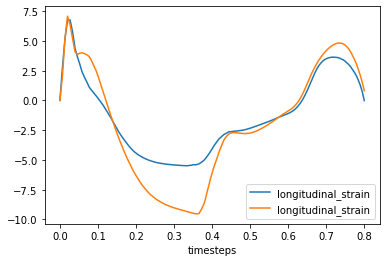

In [16]:
ax = df_typeA.plot(x="timesteps", y="longitudinal_strain")
df_ideal.plot(x="timesteps", y="longitudinal_strain", ax=ax)

<AxesSubplot:xlabel='timesteps'>

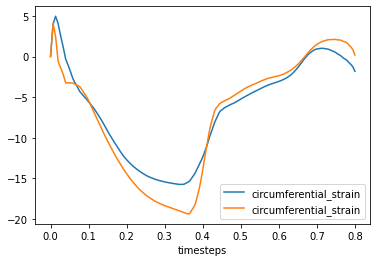

In [17]:
ax = df_typeA.plot(x="timesteps", y="circumferential_strain")
df_ideal.plot(x="timesteps", y="circumferential_strain", ax=ax)

# Extract metrics from reference file (from other papers)

In [18]:
import pandas as pd

In [19]:
xls = pd.ExcelFile("C:/Users/igorp/OneDrive - University of South Florida/Igor/Documents/References (organized)/Clinical Metrics/extracted_cms.xlsx") #pd.read_excel("./extracted_cms.xlsx")
cms = {}
for sheet_name in xls.sheet_names:
    cms[sheet_name] = xls.parse(sheet_name)

In [20]:
ts_typeA = lv_typeA.states.timesteps[10:]-0.1
ts_ideal = lv_ideal.states.timesteps[10:]-0.1


def scale_data(key, ts):
  ts_old  = cms[key]["time"].values/1000
  ts_interp = np.interp(ts_old, 
                        (ts_old.min(), ts_old.max()), 
                        (ts.min(), ts.max())) 
  try:
    val = cms[key][key.lower()].values
  except:
    val = cms[key][key].values
  return ts_interp, np.interp(ts, ts_interp, val)

In [21]:
ts_, lst_ref_typeA = scale_data("LST", ts_typeA)
_, cst_ref_typeA = scale_data("CST", ts_typeA)

In [22]:
ts_, lst_ref_ideal = scale_data("LST", ts_ideal)
_, cst_ref_ideal = scale_data("CST", ts_ideal)

In [ ]:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(1,1,figsize=(10,5))
# ax.plot(lv_typeA.states.timesteps[10:]-0.1, cst_typeA)
# ax.plot(lv_ideal.states.timesteps[10:]-0.1, cst_ideal)
# ax.plot(ts_typeA, cst_ref_typeA)

# Extract Stress/Strain data (for plotting)

In [25]:
spks = lv_typeA.get_speckles(spk_collection="circ-6_split")
lv_typeA.compute_stress(spks, reduce_by=["name", "group", "group_name"], cylindrical=False, effective=True, log_level=0)
lv_typeA.compute_strain(spks, reduce_by=["name", "group", "group_name"], cylindrical=False, effective=True, log_level=0)

INFO:LV.BaseMetricsComputations:Computing metric 'effective_stress' with 'effective' set to 'True'
INFO:LV.BaseMetricsComputations:Computing metric 'effective_Lagrange strain' with 'effective' set to 'True'


In [26]:
spks = lv_ideal.get_speckles(spk_collection="circ-6_split")
lv_ideal.compute_stress(spks, reduce_by=["name", "group", "group_name"], cylindrical=False, effective=True, log_level=0)
lv_ideal.compute_strain(spks, reduce_by=["name", "group", "group_name"], cylindrical=False, effective=True, log_level=0)

INFO:LV.BaseMetricsComputations:Computing metric 'effective_stress' with 'effective' set to 'True'
INFO:LV.BaseMetricsComputations:Computing metric 'effective_Lagrange strain' with 'effective' set to 'True'


In [63]:
spks.by("group").keys()

dict_keys(['endo', 'endo-mid', 'mid', 'mid-epi', 'epi'])

In [86]:
df1, infos1 = lv_typeA.get_metric_as_df("effective_stress")
df2, infos2 = lv_typeA.get_metric_as_df("effective_Lagrange strain")

df_typeA = pd.concat((df_typeA, df1, *list(infos1.values()), df2, *list(infos2.values())), axis=1)
df_typeA = df_typeA.loc[:,~df_typeA.columns.duplicated()].copy()

In [87]:
df1, infos1 = lv_ideal.get_metric_as_df("effective_stress")
df2, infos2 = lv_ideal.get_metric_as_df("effective_Lagrange strain")

df_ideal = pd.concat((df_ideal, df1, *list(infos1.values()), df2, *list(infos2.values())), axis=1)
df_ideal = df_ideal.loc[:,~df_ideal.columns.duplicated()].copy()

In [85]:
list(infos1.values())[-1]

,timesteps,effective_stress,effective_stress_epi_supermid,effective_stress_mid_supermid,effective_stress_epi_superapex,effective_stress_mid-epi_mid,effective_stress_endo_mid,effective_stress_mid_superapex,effective_stress_endo_apex,effective_stress_mid-epi_supermid,...,effective_stress_epi_subbase,effective_stress_endo_subbase,effective_stress_epi_superbase,effective_stress_endo_supermid,effective_stress_epi_base,effective_stress_endo_base,effective_stress_endo-mid_subapex,effective_stress_endo-mid_superapex,effective_stress_mid-epi_base,effective_stress_mid-epi_superapex
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.010000,0.006098,0.012416,0.002981,0.011603,0.007158,0.006586,0.002929,0.006178,0.007048,...,0.012355,0.007872,0.010768,0.007054,0.011860,0.008713,0.004066,0.002910,0.005224,0.006637
2,0.020000,0.008438,0.016946,0.001976,0.016450,0.006449,0.013596,0.002473,0.012317,0.005841,...,0.017025,0.014510,0.015113,0.013872,0.016543,0.014673,0.007320,0.005728,0.004437,0.006631
3,0.030000,0.010795,0.020146,0.003088,0.020356,0.006395,0.019249,0.003323,0.017293,0.005436,...,0.020176,0.019823,0.017948,0.019357,0.019618,0.019498,0.010207,0.008197,0.004435,0.006958
4,0.040000,0.013273,0.023182,0.004353,0.024202,0.006808,0.024768,0.004475,0.022454,0.005581,...,0.023151,0.024980,0.020396,0.024687,0.022450,0.024134,0.013262,0.010870,0.004842,0.007711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,0.879640,1.426436,1.165807,1.059698,1.102749,0.850074,2.771162,0.901449,2.193176,0.848984,...,1.159004,2.745170,1.044549,2.776194,1.115245,2.587079,1.303038,1.629821,0.848649,0.790953
159,0.884713,1.082441,0.908528,0.788124,0.859290,0.642782,2.100733,0.676697,1.661203,0.639720,...,0.903512,2.078059,0.813825,2.103911,0.868620,1.951527,0.990565,1.235351,0.643064,0.600422
160,0.889799,0.753234,0.644412,0.525998,0.610542,0.437169,1.478242,0.460014,1.169437,0.432227,...,0.641492,1.455614,0.579665,1.477770,0.617123,1.359439,0.697681,0.863423,0.441337,0.412737
161,0.894895,0.420858,0.397590,0.256369,0.375530,0.237546,0.851897,0.230402,0.670144,0.231166,...,0.397699,0.832920,0.360674,0.848837,0.383944,0.771733,0.386953,0.469471,0.243504,0.228880


In [80]:
infos1.keys()

dict_keys(['group', 'name', 'subset', 'group_name'])

In [81]:
infos1['group_name']

,timesteps,effective_stress,effective_stress_epi_supermid,effective_stress_mid_supermid,effective_stress_epi_superapex,effective_stress_mid-epi_mid,effective_stress_endo_mid,effective_stress_mid_superapex,effective_stress_endo_apex,effective_stress_mid-epi_supermid,...,effective_stress_epi_subbase,effective_stress_endo_subbase,effective_stress_epi_superbase,effective_stress_endo_supermid,effective_stress_epi_base,effective_stress_endo_base,effective_stress_endo-mid_subapex,effective_stress_endo-mid_superapex,effective_stress_mid-epi_base,effective_stress_mid-epi_superapex
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.010000,0.006098,0.012416,0.002981,0.011603,0.007158,0.006586,0.002929,0.006178,0.007048,...,0.012355,0.007872,0.010768,0.007054,0.011860,0.008713,0.004066,0.002910,0.005224,0.006637
2,0.020000,0.008438,0.016946,0.001976,0.016450,0.006449,0.013596,0.002473,0.012317,0.005841,...,0.017025,0.014510,0.015113,0.013872,0.016543,0.014673,0.007320,0.005728,0.004437,0.006631
3,0.030000,0.010795,0.020146,0.003088,0.020356,0.006395,0.019249,0.003323,0.017293,0.005436,...,0.020176,0.019823,0.017948,0.019357,0.019618,0.019498,0.010207,0.008197,0.004435,0.006958
4,0.040000,0.013273,0.023182,0.004353,0.024202,0.006808,0.024768,0.004475,0.022454,0.005581,...,0.023151,0.024980,0.020396,0.024687,0.022450,0.024134,0.013262,0.010870,0.004842,0.007711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,0.879640,1.426436,1.165807,1.059698,1.102749,0.850074,2.771162,0.901449,2.193176,0.848984,...,1.159004,2.745170,1.044549,2.776194,1.115245,2.587079,1.303038,1.629821,0.848649,0.790953
159,0.884713,1.082441,0.908528,0.788124,0.859290,0.642782,2.100733,0.676697,1.661203,0.639720,...,0.903512,2.078059,0.813825,2.103911,0.868620,1.951527,0.990565,1.235351,0.643064,0.600422
160,0.889799,0.753234,0.644412,0.525998,0.610542,0.437169,1.478242,0.460014,1.169437,0.432227,...,0.641492,1.455614,0.579665,1.477770,0.617123,1.359439,0.697681,0.863423,0.441337,0.412737
161,0.894895,0.420858,0.397590,0.256369,0.375530,0.237546,0.851897,0.230402,0.670144,0.231166,...,0.397699,0.832920,0.360674,0.848837,0.383944,0.771733,0.386953,0.469471,0.243504,0.228880


In [78]:
list(infos1.values())[0]

,timesteps,effective_stress,effective_stress_mid,effective_stress_endo-mid,effective_stress_epi,effective_stress_mid-epi,effective_stress_endo
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.010000,0.006098,0.006353,0.003327,0.011409,0.005946,0.006909
2,0.020000,0.008438,0.008812,0.005338,0.015955,0.005556,0.013032
3,0.030000,0.010795,0.011283,0.007606,0.019334,0.005684,0.018020
4,0.040000,0.013273,0.013859,0.010061,0.022584,0.006225,0.022940
...,...,...,...,...,...,...,...
158,0.879640,1.426436,1.506487,1.757163,1.084128,0.801963,2.452301
159,0.884713,1.082441,1.142770,1.325739,0.844673,0.608842,1.855446
160,0.889799,0.753234,0.794088,0.918692,0.600002,0.418429,1.301323
161,0.894895,0.420858,0.443414,0.492095,0.369821,0.231366,0.744586


# Modify DF

In [88]:
# df_typeA = df_typeA[df_typeA["timesteps"] >= 0.1]
# df_typeA["timesteps"] -= 0.1

df_typeA.reset_index(inplace=True)
df_typeA.drop("index", inplace=True, axis=1)

df_typeA["volume"] /= 1000

In [89]:
# df_ideal = df_ideal[df_ideal["timesteps"] >= 0.1]
# df_ideal["timesteps"] -= 0.1

df_ideal.reset_index(inplace=True)
df_ideal.drop("index", inplace=True, axis=1)

df_ideal["volume"] /= 1000

# Read Record file (inputs for simulation)

In [110]:
record_typeA = pd.read_feather(str(_dir/fn_typeA) + ".ftr")
# record_typeA = record_typeA[record_typeA["timesteps"] >= 0.1]
record_typeA.drop("timesteps", axis=1, inplace=True)

In [111]:
record_ideal = pd.read_feather(str(_dir/fn_ideal) + ".ftr")
# record_ideal = record_ideal[record_ideal["timesteps"] >= 0.1]
record_ideal.drop("timesteps", axis=1, inplace=True)

In [112]:
record_typeA

,P_n,V_n,P_s,V_s,gw_est,gw,endo,epi,endo_est,epi_est,cm_LS,cm_RS,cm_WT,cm_SL,cm_SC,cm_EF,cd_EF
0,0.000100,1.000000,0.001600,95.000000,0.022848,0.022848,57.536678,64.397835,57.536678,64.397835,0.19,0.35,0.28,0.2,0.35,0.57549,0.000058
1,0.103836,0.997705,1.661371,94.781998,0.038022,0.038022,57.536678,64.397835,57.536678,64.397835,0.19,0.35,0.28,0.2,0.35,0.57549,0.000058
2,0.204762,0.995595,3.276187,94.581520,0.053197,0.053197,57.536678,64.397835,57.536678,64.397835,0.19,0.35,0.28,0.2,0.35,0.57549,0.000058
3,0.302451,0.993697,4.839208,94.401245,0.068371,0.068371,57.536678,64.397835,57.536678,64.397835,0.19,0.35,0.28,0.2,0.35,0.57549,0.000058
4,0.388099,0.989711,6.209587,94.022530,0.086130,0.086130,57.536678,64.397835,57.536678,64.397835,0.19,0.35,0.28,0.2,0.35,0.57549,0.000058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,0.034962,1.000000,0.559390,95.000000,0.047567,0.047567,57.536678,64.397835,57.536678,64.397835,0.19,0.35,0.28,0.2,0.35,0.57549,0.000058
149,0.026904,1.000000,0.430461,95.000000,0.045758,0.045758,57.536678,64.397835,57.536678,64.397835,0.19,0.35,0.28,0.2,0.35,0.57549,0.000058
150,0.019207,1.000000,0.307304,95.000000,0.043522,0.043522,57.536678,64.397835,57.536678,64.397835,0.19,0.35,0.28,0.2,0.35,0.57549,0.000058
151,0.010215,1.000000,0.163439,95.000000,0.041287,0.041287,57.536678,64.397835,57.536678,64.397835,0.19,0.35,0.28,0.2,0.35,0.57549,0.000058


In [113]:
record_ideal

,P_n,V_n,P_s,V_s,gw_est,gw,endo,epi,endo_est,epi_est,cm_LS,cm_RS,cm_WT,cm_SL,cm_SC,cm_EF,cd_EF
0,0.000100,1.000000,0.001600,95.000000,0.007547,0.007547,69.929321,44.006271,69.929321,44.006271,0.19,0.35,0.28,0.2,0.35,0.57549,0.000058
1,0.103836,0.997705,1.661371,94.781998,0.037857,0.037857,69.929321,44.006271,69.929321,44.006271,0.19,0.35,0.28,0.2,0.35,0.57549,0.000058
2,0.204762,0.995595,3.276187,94.581520,0.068167,0.068167,69.929321,44.006271,69.929321,44.006271,0.19,0.35,0.28,0.2,0.35,0.57549,0.000058
3,0.302451,0.993697,4.839208,94.401245,0.098477,0.098477,69.929321,44.006271,69.929321,44.006271,0.19,0.35,0.28,0.2,0.35,0.57549,0.000058
4,0.388099,0.989711,6.209587,94.022530,0.113556,0.113556,69.929321,44.006271,69.929321,44.006271,0.19,0.35,0.28,0.2,0.35,0.57549,0.000058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,0.034962,1.000000,0.559390,95.000000,0.018860,0.018860,69.929321,44.006271,69.929321,44.006271,0.19,0.35,0.28,0.2,0.35,0.57549,0.000058
149,0.026904,1.000000,0.430461,95.000000,0.015693,0.015693,69.929321,44.006271,69.929321,44.006271,0.19,0.35,0.28,0.2,0.35,0.57549,0.000058
150,0.019207,1.000000,0.307304,95.000000,0.011813,0.011813,69.929321,44.006271,69.929321,44.006271,0.19,0.35,0.28,0.2,0.35,0.57549,0.000058
151,0.010215,1.000000,0.163439,95.000000,0.007934,0.007934,69.929321,44.006271,69.929321,44.006271,0.19,0.35,0.28,0.2,0.35,0.57549,0.000058


In [114]:
record_typeA["P_n"]

0      0.000100
1      0.103836
2      0.204762
3      0.302451
4      0.388099
         ...   
148    0.034962
149    0.026904
150    0.019207
151    0.010215
152    0.000100
Name: P_n, Length: 153, dtype: float64

# Add data to DF

In [115]:
df_typeA["Pressure"] = record_typeA["P_s"]
df_typeA["Volume"] = record_typeA["V_s"]
df_typeA["Gamma"] = record_typeA["gw"]

# df_typeA["CST"] = cst_typeA
# df_typeA["LST"] = lst_typeA
# df_typeA["CST_REF"] = cst_ref_typeA
# df_typeA["LST_REF"] = lst_ref_typeA

In [116]:
df_ideal["Pressure"] = record_ideal["P_s"]
df_ideal["Volume"] = record_ideal["V_s"]
df_ideal["Gamma"] = record_ideal["gw"]

# df_ideal["CST"] = cst_ideal
# df_ideal["LST"] = lst_ideal
# df_ideal["CST_REF"] = cst_ref_ideal
# df_ideal["LST_REF"] = lst_ref_ideal

In [39]:
# df_typeA.plot(x="timesteps", y=["CST", "CST_REF"])

# resize data

In [117]:
record_typeA

,P_n,V_n,P_s,V_s,gw_est,gw,endo,epi,endo_est,epi_est,cm_LS,cm_RS,cm_WT,cm_SL,cm_SC,cm_EF,cd_EF
0,0.000100,1.000000,0.001600,95.000000,0.022848,0.022848,57.536678,64.397835,57.536678,64.397835,0.19,0.35,0.28,0.2,0.35,0.57549,0.000058
1,0.103836,0.997705,1.661371,94.781998,0.038022,0.038022,57.536678,64.397835,57.536678,64.397835,0.19,0.35,0.28,0.2,0.35,0.57549,0.000058
2,0.204762,0.995595,3.276187,94.581520,0.053197,0.053197,57.536678,64.397835,57.536678,64.397835,0.19,0.35,0.28,0.2,0.35,0.57549,0.000058
3,0.302451,0.993697,4.839208,94.401245,0.068371,0.068371,57.536678,64.397835,57.536678,64.397835,0.19,0.35,0.28,0.2,0.35,0.57549,0.000058
4,0.388099,0.989711,6.209587,94.022530,0.086130,0.086130,57.536678,64.397835,57.536678,64.397835,0.19,0.35,0.28,0.2,0.35,0.57549,0.000058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,0.034962,1.000000,0.559390,95.000000,0.047567,0.047567,57.536678,64.397835,57.536678,64.397835,0.19,0.35,0.28,0.2,0.35,0.57549,0.000058
149,0.026904,1.000000,0.430461,95.000000,0.045758,0.045758,57.536678,64.397835,57.536678,64.397835,0.19,0.35,0.28,0.2,0.35,0.57549,0.000058
150,0.019207,1.000000,0.307304,95.000000,0.043522,0.043522,57.536678,64.397835,57.536678,64.397835,0.19,0.35,0.28,0.2,0.35,0.57549,0.000058
151,0.010215,1.000000,0.163439,95.000000,0.041287,0.041287,57.536678,64.397835,57.536678,64.397835,0.19,0.35,0.28,0.2,0.35,0.57549,0.000058


In [96]:
ts = np.linspace(0, 0.79999, 100)

def resize(arr, ts_old, ts_new):
    return np.interp(ts_new, ts_old, arr)

In [118]:
resize(record_typeA["P_n"].values, record_typeA["timestep"].values, ts)

KeyError: 'timestep'

In [97]:
data_typeA = df_typeA.values
ts_old = df_typeA["timesteps"].values
resized_data_typeA = np.hstack([resize(df_typeA[col], ts_old, ts).reshape((-1,1)) for col in df_typeA])

In [98]:
data_ideal = df_ideal.values
ts_old = df_ideal["timesteps"].values
resized_data_ideal = np.hstack([resize(df_ideal[col], ts_old, ts).reshape((-1,1)) for col in df_ideal])

In [99]:
resized_df_typeA = pd.DataFrame(resized_data_typeA, columns=df_typeA.columns)
resized_df_ideal = pd.DataFrame(resized_data_ideal, columns=df_ideal.columns)

In [100]:
resized_df_typeA["type"] = "patient"
resized_df_ideal["type"] = "ideal"

In [101]:
df = pd.concat((resized_df_typeA, resized_df_ideal))

In [102]:
df = df.loc[:,~df.columns.duplicated()].copy()

In [103]:
df

,timesteps,volume,longitudinal_distance,longitudinal_distance_epi,longitudinal_distance_endo,radial_distance,radial_distance_epi,radial_distance_endo,radial_distance_wall,radial_distance_submid,...,effective_Lagrange strain_epi_base,effective_Lagrange strain_endo_base,effective_Lagrange strain_endo-mid_subapex,effective_Lagrange strain_endo-mid_superapex,effective_Lagrange strain_mid-epi_base,effective_Lagrange strain_mid-epi_superapex,Pressure,Volume,Gamma,type
0,0.000000,0.087959,79.963472,85.388169,74.538775,24.239093,31.546995,17.158182,24.012103,24.544022,...,0.034379,0.066721,0.065835,0.060291,0.038190,0.037804,0.001600,95.000000,0.022848,patient
1,0.008081,0.102703,82.356058,87.727159,76.984956,25.277969,32.272273,18.561705,24.999929,25.658107,...,0.050332,0.081917,0.277453,0.165822,0.067581,0.104861,2.003883,94.739475,0.041241,patient
2,0.016161,0.108600,84.957580,90.183757,79.731403,25.373227,32.191445,18.849703,25.078532,25.708351,...,0.090940,0.182530,0.363507,0.273255,0.119764,0.192082,3.939240,94.505045,0.059634,patient
3,0.024242,0.106369,86.257410,91.312010,81.202810,24.974023,31.795094,18.450648,24.676327,25.333517,...,0.119519,0.257276,0.415832,0.328237,0.144957,0.229265,5.711206,94.160261,0.079671,patient
4,0.032323,0.100008,85.621064,90.652103,80.590025,24.526730,31.499169,17.848897,24.232126,24.859892,...,0.129796,0.272106,0.457578,0.367859,0.148771,0.255936,7.313137,93.605360,0.101288,patient
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.767667,0.132969,93.077812,97.872062,88.283562,26.761409,31.734143,22.054164,26.495920,27.229604,...,0.083315,0.100970,0.180184,0.142683,0.094177,0.109884,0.822746,95.000000,0.026076,ideal
96,0.775748,0.131339,92.551794,97.369279,87.734309,26.726003,31.719093,21.994606,26.464310,27.201242,...,0.071045,0.086411,0.154442,0.120626,0.080356,0.091233,0.650838,95.000000,0.021272,ideal
97,0.783829,0.128806,91.907120,96.756795,87.057444,26.644449,31.669837,21.875132,26.388377,27.128107,...,0.055443,0.066996,0.120340,0.092113,0.062716,0.068814,0.452947,95.000000,0.016245,ideal
98,0.791909,0.125609,91.128401,96.016402,86.240400,26.536010,31.603446,21.716154,26.288430,27.033248,...,0.035868,0.042364,0.074828,0.055991,0.040391,0.042241,0.247724,95.000000,0.010207,ideal


In [58]:
df.to_csv(_dir/"healthy_results.csv")

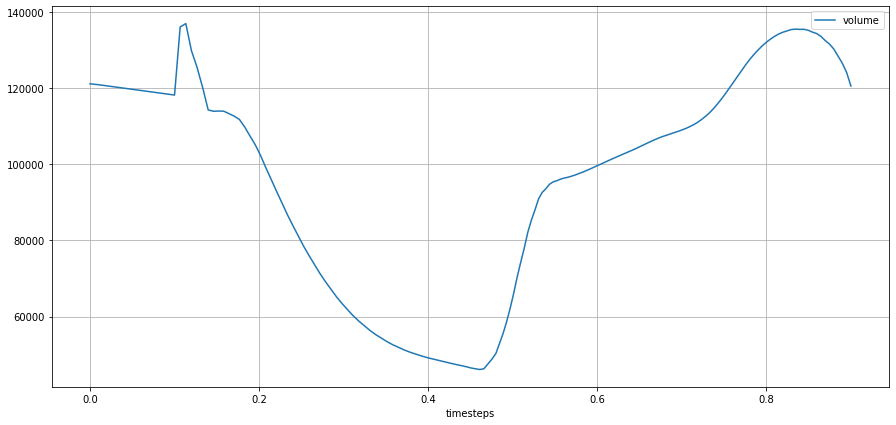

In [59]:
lv_ideal.plot_metric("volume")